In [1]:
!pip install -q transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.2 MB/s eta 0:00:00


In [2]:
!pip install pyarrow

In [3]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00


In [4]:
!pip -q install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


## Load data

In [5]:
import wandb

In [6]:
from urllib import request
import pandas as pd
from collections import Counter
import random
import numpy as np
import pandas as pd
import copy
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import torch
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification

In [7]:
import datasets
from datasets import Dataset
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import Trainer

In [8]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [9]:
from dont_patronize_me import DontPatronizeMe

In [10]:
def set_seeds(seed=42):
    """
    Set random seeds for NumPy and PyTorch.

    Parameters:
    - seed (int): The seed value to set for random number generators.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [11]:
dpm = DontPatronizeMe('.', 'task4_test.tsv')

In [12]:
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [13]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [14]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [15]:
set_seeds()
data=dpm.train_task1_df
data

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


In [ ]:
data

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
6985,6986,@@23941242,immigrant,us,"""Agnew was among the first -- perhaps because ...",0,0
6986,6987,@@7461272,in-need,gb,"""He said he had told his officers to """" befrie...",1,3
6987,6988,@@16437918,homeless,bd,"After Vatican controversy , McDonald 's helps ...",1,3
6988,6989,@@14915031,hopeless,hk,It would be nice and neat if you could blame t...,0,0


In [16]:
set_seeds()
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })

trdf1 = pd.DataFrame(rows)
trdf1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1
...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,0
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,0
8372,8382,homeless,"The unrest has left at least 20,000 people dea...",0
8373,8383,hopeless,You have to see it from my perspective . I may...,0


In [17]:
set_seeds()
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })
tedf1 = pd.DataFrame(rows)
tedf1

,par_id,community,text,label
0,4046,hopeless,We also know that they can benefit by receivin...,1
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1
...,...,...,...,...
2089,10462,homeless,"The sad spectacle , which occurred on Saturday...",0
2090,10463,refugee,""""""" The Pakistani police came to our house and...",0
2091,10464,disabled,"""When Marie O'Donoghue went looking for a spec...",0
2092,10465,women,"""Sri Lankan norms and culture inhibit women fr...",0


In [18]:
rows_list = tedf1.values.tolist()

In [19]:
random.seed(42)
# Shuffle the list using random.shuffle
random.shuffle(rows_list)

In [20]:
# Create a new DataFrame from the shuffled list
tedf1 = pd.DataFrame(rows_list, columns=tedf1.columns)
tedf1

,par_id,community,text,label
0,9830,hopeless,Since Mr. Cruz 's election to the Senate in 20...,0
1,9165,refugee,These are some of the dilemmas that befell Min...,0
2,9265,immigrant,"Lucy Lawless ( Salem , Spartacus ) as Ruby , a...",0
3,8457,refugee,The situation has some parallels to Myanmar 's...,0
4,10122,poor-families,"Five years down the lane , the schools whose l...",0
...,...,...,...,...
2089,9170,migrant,"This May 5 , 2018 , photo , released by the Ro...",0
2090,9264,vulnerable,"""Asim Qureshi , of Cageprisoners , says that h...",0
2091,9396,immigrant,Mr Ariel told ministry of housing staff and of...,0
2092,2953,poor-families,""""""" The worst thing was dealt to us , """" he sa...",1


In [21]:
import datasets
from datasets import Dataset
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import Trainer

In [22]:
# Split the dataset into train and test sets
train_df, val_df = train_test_split(trdf1, test_size=0.2, random_state=42)

train_dataset =  Dataset.from_dict({"data": train_df["text"], "label": train_df["label"]}).with_format("torch")
val_dataset =  Dataset.from_dict({"data": val_df["text"], "label": val_df["label"]}).with_format("torch")
test_dataset =  Dataset.from_dict({"data": tedf1["text"], "label": tedf1["label"]}).with_format("torch")

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

6700
1675
2094


In [23]:
def tokenize_function(example):
    return tokenizer(example["data"], truncation=True)


In [24]:
from sklearn.metrics import accuracy_score, f1_score

# Define evaluation metrics function
def compute_metrics(p):
    predictions = p.predictions.argmax(axis=1)
    labels = p.label_ids

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary')


    # return {"accuracy": accuracy, "f1": f1, "predictions": list(predictions)}
    return {"accuracy": accuracy, "f1": f1}

In [25]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [26]:
tedf1.to_csv('tedf1_fi.csv')
trdf1.to_csv('trdf1_fi.csv')

In [27]:
train_df.to_csv('train_fi.csv')
val_df.to_csv('val_fi.csv')

## Roberta Hate speech

In [ ]:
# Load model

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-hate-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-hate-latest", num_labels=2)

tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/888 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6700 [00:00<?, ? examples/s]

Map:   0%|          | 0/1675 [00:00<?, ? examples/s]

Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

In [29]:
# Calculate class frequencies
class_counts = Counter(trdf1['label'])

class_counts

Counter({1: 794, 0: 7581})

In [30]:
# Calculate class frequencies
class_counts = Counter(trdf1['label'])

# Calculate total number of samples
total_samples = sum(class_counts.values())

# Calculate class weights
class_weights = [total_samples / (class_counts[label] * len(class_counts)) for label in range(len(class_counts))]

# Normalize class weights to sum to 1
class_weights = torch.tensor(class_weights) / sum(class_weights)

print("Class Weights:", class_weights.tolist())

Class Weights: [0.09480596333742142, 0.9051940441131592]


In [31]:
from torch import nn
from transformers import Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        device = logits.device
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.09480596333742142, 0.9051940441131592], device=device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
batch_size = 16

training_args = TrainingArguments("train_logs", evaluation_strategy="epoch",\
                                  learning_rate=2e-6,
                                  num_train_epochs=10,
                                  lr_scheduler_type="cosine",
                                  optim = "adamw_torch",
                                  weight_decay=0,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  run_name="roberta-base-hate-best",  # name of the W&B run (optional)
                                  logging_steps=1,  # how often to log to W&B
                                  )


trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.460000,1.120955,0.903284,0.526316
2,0.000800,1.296334,0.906269,0.525680
3,0.000900,1.494531,0.913433,0.515050
4,0.950200,1.403861,0.906269,0.544928
5,0.000300,1.506064,0.908060,0.541667
6,0.000600,1.477294,0.902687,0.545961
7,0.002000,1.544883,0.902687,0.532951
8,0.000200,1.550270,0.905672,0.548571
9,0.127900,1.564780,0.902687,0.535613
10,0.017400,1.606661,0.905075,0.533724


Checkpoint destination directory train_logs/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory train_logs/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory train_logs/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory train_logs/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory train_logs/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory train_logs/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory train_logs/checkpoint-3500 already exists and is non-empty. Saving will proceed but sa

TrainOutput(global_step=4190, training_loss=0.17862468226139017, metrics={'train_runtime': 591.9829, 'train_samples_per_second': 113.179, 'train_steps_per_second': 7.078, 'total_flos': 4431694616515200.0, 'train_loss': 0.17862468226139017, 'epoch': 10.0})

In [ ]:
predictions_val_roberta = trainer.predict(tokenized_val_dataset).predictions
print(predictions_val_roberta.shape)
predictions_val_roberta_lables = predictions_val_roberta.argmax(axis=1)
predictions_val_roberta_lables

(1675, 2)


array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
labels2file([[k] for k in predictions_val_roberta_lables], 'val_roberta_cw.txt')

In [ ]:
trainer.predict(tokenized_val_dataset).metrics

{'test_loss': 1.6066608428955078,
 'test_accuracy': 0.9050746268656716,
 'test_f1': 0.533724340175953,
 'test_runtime': 3.8983,
 'test_samples_per_second': 429.676,
 'test_steps_per_second': 26.935}

In [ ]:
results = trainer.evaluate(tokenized_val_dataset)

print(results)

{'eval_loss': 1.6066608428955078, 'eval_accuracy': 0.9050746268656716, 'eval_f1': 0.533724340175953, 'eval_runtime': 3.8551, 'eval_samples_per_second': 434.49, 'eval_steps_per_second': 27.237, 'epoch': 10.0}


In [ ]:
predictions_test_roberta = trainer.predict(tokenized_test_dataset)
print(predictions_test_roberta.metrics)

predictions_test_roberta_labels = predictions_test_roberta.predictions.argmax(axis=1)
predictions_test_roberta

{'test_loss': 1.2928416728973389, 'test_accuracy': 0.9178605539637058, 'test_f1': 0.5924170616113744, 'test_runtime': 5.0721, 'test_samples_per_second': 412.849, 'test_steps_per_second': 25.828}


PredictionOutput(predictions=array([[ 4.828707 , -4.550371 ],
       [ 4.7248936, -4.4404254],
       [ 4.6078343, -4.3276243],
       ...,
       [ 4.7206   , -4.5144105],
       [-4.564427 ,  4.095601 ],
       [ 4.8037405, -4.5251813]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 1, 0]), metrics={'test_loss': 1.2928416728973389, 'test_accuracy': 0.9178605539637058, 'test_f1': 0.5924170616113744, 'test_runtime': 5.0721, 'test_samples_per_second': 412.849, 'test_steps_per_second': 25.828})

In [ ]:
labels2file([[k] for k in predictions_test_roberta_labels], 'dev_roberta.txt')

In [ ]:
Counter(predictions_test_roberta_labels)

Counter({0: 1907, 1: 187})

In [48]:
dpm.load_test()
test_df = dpm.test_set_df

In [49]:
test_df

,par_id,art_id,keyword,country,text
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to..."
1,t_1,@@16397324,women,pk,In most poor households with no education chil...
2,t_2,@@16257812,migrant,ca,The real question is not whether immigration i...
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population..."
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C..."
...,...,...,...,...,...
3827,t_3893,@@20319448,migrant,jm,In a letter dated Thursday to European Commiss...
3828,t_3894,@@9990672,poor-families,au,They discovered that poor families with health...
3829,t_3895,@@37984,migrant,ca,"She married at 19 , to Milan ( Emil ) Badovina..."
3830,t_3896,@@9691377,immigrant,us,The United Kingdom is n't going to devolve int...


In [50]:
official_test_dataset =  Dataset.from_dict({"data": test_df["text"]}).with_format("torch")

In [51]:
official_test_dataset

Dataset({
    features: ['data'],
    num_rows: 3832
})

In [ ]:

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-hate-latest")
tokenized_official_test_dataset = official_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3832 [00:00<?, ? examples/s]

In [ ]:
predictions_roberta_testoff = trainer.predict(tokenized_official_test_dataset)
print(predictions_roberta_testoff.metrics)

predictions_roberta_testoff_labels = predictions_roberta_testoff.predictions.argmax(axis=1)
predictions_roberta_testoff_labels

{'test_runtime': 9.0069, 'test_samples_per_second': 425.45, 'test_steps_per_second': 26.646}


array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
labels2file([[k] for k in predictions_roberta_testoff_labels], 'test_roberta.txt')

In [ ]:
torch.save(predictions_val_roberta, 'val_pred_roberta_m.pt')
torch.save(predictions_test_roberta, 'dev_pred_roberta_m.pt')
torch.save(predictions_roberta_testoff, 'test_pred_roberta_m.pt')


## Deberta

In [32]:
from transformers import DebertaForSequenceClassification, DebertaTokenizer, AdamW
import torch

In [33]:
model_name = 'microsoft/deberta-base'
model = DebertaForSequenceClassification.from_pretrained(model_name)
tokenizer = DebertaTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [34]:
def tokenize_function(example):
    return tokenizer(example["data"], truncation=True)


tokenized_train_dataset_De = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset_De = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset_De = test_dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6700 [00:00<?, ? examples/s]

Map:   0%|          | 0/1675 [00:00<?, ? examples/s]

Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

In [35]:
batch_size = 8

training_args1 = TrainingArguments("train_logs", evaluation_strategy="epoch",\
                                  learning_rate=2e-6,
                                  num_train_epochs=10,
                                  lr_scheduler_type="cosine",
                                  optim = "adamw_torch",
                                  weight_decay=0,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  run_name="Deberta-ms",  # name of the W&B run (optional)
                                  logging_steps=1,  # how often to log to W&B
                                                                  )


trainer = CustomTrainer(
    model,
    training_args1,
    train_dataset=tokenized_train_dataset_De,
    eval_dataset=tokenized_val_dataset_De,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [36]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.194200,0.553548,0.895522,0.480712
2,0.004700,0.914461,0.917015,0.475472
3,0.004400,1.049104,0.920597,0.424242
4,0.913000,0.786916,0.904478,0.537572
5,0.002500,0.903880,0.910448,0.528302
6,0.891900,0.893242,0.904478,0.537572
7,0.001900,1.029385,0.912836,0.543750
8,0.001400,1.032456,0.912239,0.544892
9,0.063900,1.049649,0.911045,0.538700
10,0.195900,1.043353,0.909851,0.541033


TrainOutput(global_step=8380, training_loss=0.48687798121495635, metrics={'train_runtime': 1111.886, 'train_samples_per_second': 60.258, 'train_steps_per_second': 7.537, 'total_flos': 4350167222584464.0, 'train_loss': 0.48687798121495635, 'epoch': 10.0})

In [37]:
predictions_val_deberta = trainer.predict(tokenized_val_dataset_De).predictions
print(predictions_val_deberta.shape)
predictions_val_deberta_lables = predictions_val_deberta.argmax(axis=1)
predictions_val_deberta_lables

(1675, 2)


array([0, 0, 0, ..., 0, 0, 0])

In [38]:
trainer.predict(tokenized_val_dataset_De).metrics

{'test_loss': 1.0433530807495117,
 'test_accuracy': 0.9098507462686567,
 'test_f1': 0.541033434650456,
 'test_runtime': 6.5201,
 'test_samples_per_second': 256.899,
 'test_steps_per_second': 32.208}

In [39]:
predictions_test_deberta = trainer.predict(tokenized_test_dataset_De)
print(predictions_test_deberta.metrics)

predictions_test_deberta_labels = predictions_test_deberta.predictions.argmax(axis=1)
predictions_test_deberta

{'test_loss': 0.8330684304237366, 'test_accuracy': 0.9235912129894938, 'test_f1': 0.5979899497487438, 'test_runtime': 8.3091, 'test_samples_per_second': 252.012, 'test_steps_per_second': 31.532}


PredictionOutput(predictions=array([[ 3.5556219, -3.7173994],
       [ 3.4046707, -3.497541 ],
       [ 3.4162123, -3.3719938],
       ...,
       [ 3.5017123, -3.800229 ],
       [-1.5980142,  1.3632677],
       [ 3.5174677, -3.8715243]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 1, 0]), metrics={'test_loss': 0.8330684304237366, 'test_accuracy': 0.9235912129894938, 'test_f1': 0.5979899497487438, 'test_runtime': 8.3091, 'test_samples_per_second': 252.012, 'test_steps_per_second': 31.532})

In [40]:
labels2file([[k] for k in predictions_val_deberta_lables], 'val_deberta.txt')

In [41]:
labels2file([[k] for k in predictions_test_deberta_labels], 'dev_deberta.txt')

In [52]:
tokenized_official_test_dataset = official_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3832 [00:00<?, ? examples/s]

In [53]:
predictions_deberta_testoff = trainer.predict(tokenized_official_test_dataset)
print(predictions_deberta_testoff.metrics)

predictions_deberta_testoff_labels = predictions_deberta_testoff.predictions.argmax(axis=1)
predictions_deberta_testoff_labels

{'test_runtime': 15.3262, 'test_samples_per_second': 250.029, 'test_steps_per_second': 31.254}


array([0, 0, 0, ..., 0, 0, 0])

In [54]:
labels2file([[k] for k in predictions_deberta_testoff_labels], 'test_deberta.txt')

## Ensemble Scores

In [55]:
torch.save(predictions_val_deberta, 'val_pred_deberta_m.pt')
torch.save(predictions_test_deberta, 'dev_pred_deberta_m.pt')
torch.save(predictions_deberta_testoff, 'test_pred_deberta_m.pt')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


labels_model_test= val_dataset['label']


summed_logits = predictions_val_deberta + predictions_val_roberta

# Choose the class with the higher sum
ensemble_predictions_val = np.argmax(summed_logits, axis=1)

accuracy = accuracy_score(labels_model_test, ensemble_predictions_val)
precision = precision_score(labels_model_test, ensemble_predictions_val)
recall = recall_score(labels_model_test, ensemble_predictions_val)
f1 = f1_score(labels_model_test, ensemble_predictions_val)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9116
Precision: 0.5569
Recall: 0.5569
F1 Score: 0.5569


In [ ]:
labels2file([[k] for k in ensemble_predictions_val], 'val.txt')

In [ ]:
predictions_test_roberta = torch.load('/content/dev_pred_roberta_m.pt')

In [ ]:
# Sum up the logits
summed_logits = predictions_test_deberta[0] + predictions_test_roberta[0]

# Choose the class with the higher sum
ensemble_predictions = np.argmax(summed_logits, axis=1)

accuracy = accuracy_score(labels_model_test, ensemble_predictions)
precision = precision_score(labels_model_test, ensemble_predictions)
recall = recall_score(labels_model_test, ensemble_predictions)
f1 = f1_score(labels_model_test, ensemble_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9260
Precision: 0.6068
Recall: 0.6281
F1 Score: 0.6173


In [ ]:
ensemble_predictions

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
labels2file([[k] for k in ensemble_predictions], 'dev.txt')

In [56]:
predictions_roberta_testoff = torch.load('/content/test_pred_roberta_m.pt')

In [57]:
# Test Set Results
summed_logits = predictions_roberta_testoff[0] + predictions_deberta_testoff[0]

# Hard voting ensemble
ensemble_predictions_testoff = np.argmax(summed_logits, axis=1)



In [58]:
ensemble_predictions_testoff.shape

(3832,)

In [59]:
ensemble_predictions_testoff

array([0, 0, 0, ..., 0, 0, 0])

In [60]:
labels2file([[k] for k in ensemble_predictions_testoff], 'test.txt')

In [61]:
import shutil

# Replace 'folder_to_zip' with the path of the folder you want to zip
folder_path = '/content/final_data_with_cw'

# Replace 'output.zip' with the desired name for the zip file
zip_filename = '/content/final_data_with_cw_again'

# Create a zip file
shutil.make_archive(zip_filename, 'zip', folder_path)

print(f"Folder '{folder_path}' zipped successfully as '{zip_filename}'")

Folder '/content/final_data_with_cw' zipped successfully as '/content/final_data_with_cw_again'


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


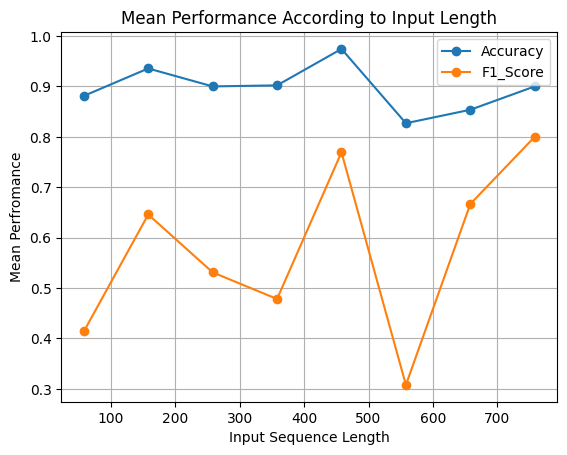

In [ ]:
def sliding_bin_performance(input_lengths, window_size, predicted_labels, ground_truth):

    # Create bins
    min_value = min(input_lengths)
    max_value = max(input_lengths)
    bin_centers = np.arange(min_value + window_size / 2, max_value, window_size)
    num_bins = len(bin_centers)

    acc_metrics = np.zeros(num_bins)
    f1_metrics = np.zeros(num_bins)

    # Iterate through bins
    for i in range(num_bins):
        bin_start = int(bin_centers[i] - window_size / 2)
        bin_end = int(bin_centers[i] + window_size / 2)

        # Select sequences within the current bin
        bin_indices = np.where((input_lengths >= bin_start) & (input_lengths < bin_end))[0]

        # Store mean performance for the bin
        acc_metrics[i] = calculate_accuracy(predicted_labels[bin_indices], ground_truth[bin_indices])
        f1_metrics[i] = calculate_f1_score(predicted_labels[bin_indices], ground_truth[bin_indices])

    return bin_centers, acc_metrics, f1_metrics

def calculate_accuracy(predicted_labels, ground_truth):

    return accuracy_score(predicted_labels, ground_truth)

def calculate_f1_score(predicted_labels, ground_truth):

    return f1_score(predicted_labels, ground_truth)

input_lengths = [len(str(text)) for text in val_df['text']]
input_lengths = np.array(input_lengths)
window_size = 100

predicted_labels = ensemble_predictions_val
ground_truth = np.array(val_df['label'])

bin_centers, acc_performance, f1_performance = sliding_bin_performance(input_lengths, window_size, predicted_labels, ground_truth)

# Plot the results
import matplotlib.pyplot as plt

plt.plot(bin_centers[:-2], acc_performance[:-2], marker='o', label='Accuracy')
plt.plot(bin_centers[:-2], f1_performance[:-2], marker='o', label='F1_Score')
plt.title('Mean Performance According to Input Length')
plt.xlabel('Input Sequence Length')
plt.ylabel('Mean Perfromance')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_clas

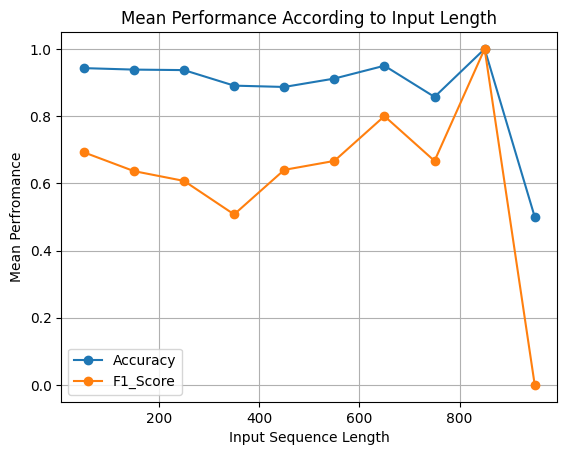

In [ ]:
def sliding_bin_performance(input_lengths, window_size, predicted_labels, ground_truth):

    # Create bins
    min_value = min(input_lengths)
    max_value = max(input_lengths)
    bin_centers = np.arange(min_value + window_size / 2, max_value, window_size)
    num_bins = len(bin_centers)

    acc_metrics = np.zeros(num_bins)
    f1_metrics = np.zeros(num_bins)

    # Iterate through bins
    for i in range(num_bins):
        bin_start = int(bin_centers[i] - window_size / 2)
        bin_end = int(bin_centers[i] + window_size / 2)

        # Select sequences within the current bin
        bin_indices = np.where((input_lengths >= bin_start) & (input_lengths < bin_end))[0]

        # Store mean performance for the bin
        acc_metrics[i] = calculate_accuracy(predicted_labels[bin_indices], ground_truth[bin_indices])
        f1_metrics[i] = calculate_f1_score(predicted_labels[bin_indices], ground_truth[bin_indices])

    return bin_centers, acc_metrics, f1_metrics

def calculate_accuracy(predicted_labels, ground_truth):

    return accuracy_score(predicted_labels, ground_truth)

def calculate_f1_score(predicted_labels, ground_truth):

    return f1_score(predicted_labels, ground_truth)

input_lengths = [len(str(text)) for text in tedf1['text']]
input_lengths = np.array(input_lengths)
window_size = 100
predicted_labels = ensemble_predictions
ground_truth = np.array(tedf1['label'])

bin_centers, acc_performance, f1_performance = sliding_bin_performance(input_lengths, window_size, predicted_labels, ground_truth)

# Plot the results
import matplotlib.pyplot as plt

plt.plot(bin_centers[:-4], acc_performance[:-4], marker='o', label='Accuracy')
plt.plot(bin_centers[:-4], f1_performance[:-4], marker='o', label='F1_Score')
plt.title('Mean Performance According to Input Length')
plt.xlabel('Input Sequence Length')
plt.ylabel('Mean Perfromance')
plt.legend()
plt.grid(True)
plt.show()


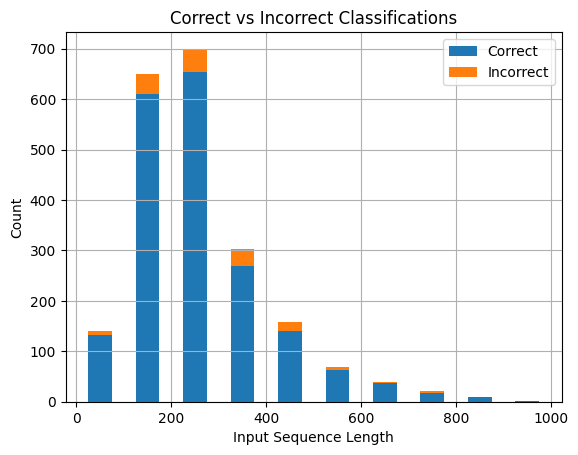

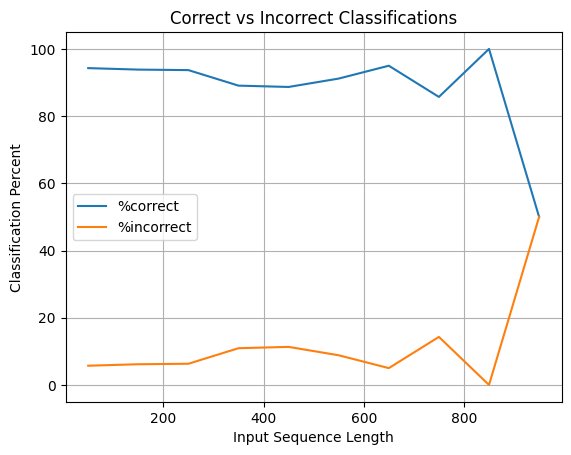

In [ ]:

def sliding_bin_correct_incorrect(input_lengths, window_size, predicted_labels, ground_truth):

    # Create bins
    min_value = min(input_lengths)
    max_value = max(input_lengths)
    bin_centers = np.arange(min_value + window_size / 2, max_value, window_size)
    num_bins = len(bin_centers)

    # Initialize arrays to store counts for each bin
    correct_counts = np.zeros(num_bins)
    incorrect_counts = np.zeros(num_bins)
    bin_lengths = np.zeros(num_bins)

    # Iterate through bins
    for i in range(num_bins):
        bin_start = int(bin_centers[i] - window_size / 2)
        bin_end = int(bin_centers[i] + window_size / 2)

        # Select sequences within the current bin
        bin_indices = np.where((input_lengths >= bin_start) & (input_lengths < bin_end))[0]
        bin_lengths[i] = len(bin_indices)

        # Calculate correct and incorrect counts for the selected sequences
        correct_indices = np.where(predicted_labels[bin_indices] == ground_truth[bin_indices])[0]
        incorrect_indices = np.where(predicted_labels[bin_indices] != ground_truth[bin_indices])[0]

        # Store counts for the bin
        correct_counts[i] = len(correct_indices)
        incorrect_counts[i] = len(incorrect_indices)

    return bin_centers, correct_counts, incorrect_counts,bin_lengths

input_lengths = [len(str(text)) for text in tedf1['text']]
input_lengths = np.array(input_lengths)
window_size = 100

predicted_labels =  ensemble_predictions
ground_truth = np.array(tedf1['label'])

bin_centers, correct_counts, incorrect_counts,bin_lengths = sliding_bin_correct_incorrect(
    input_lengths, window_size, predicted_labels, ground_truth
)

# Plot the results
plt.figure()
bar_width = 50
plt.bar(bin_centers[:-4], correct_counts[:-4], width=bar_width, label='Correct')
plt.bar(bin_centers[:-4], incorrect_counts[:-4], width=bar_width, label='Incorrect', bottom=correct_counts[:-4])

plt.title('Correct vs Incorrect Classifications')
plt.xlabel('Input Sequence Length')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results
plt.figure()
bar_width = 200
plt.plot(bin_centers[:-4], ((correct_counts[:-4]/bin_lengths[:-4])*100), label='%correct')
plt.plot(bin_centers[:-4], ((incorrect_counts[:-4]/bin_lengths[:-4])*100), label='%incorrect')

plt.title('Correct vs Incorrect Classifications')
plt.xlabel('Input Sequence Length')
plt.ylabel('Classification Percent')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
len(tedf1['label'][np.where(input_lengths>800)[0]])


16

In [ ]:
condition = (input_lengths > 200) & (input_lengths < 400)


In [ ]:
len(np.where(tedf1['label'][(np.where(condition))[0]]==1)[0])

91